### Importing Libraries

In [192]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

In [193]:
# Set display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', None)  # Prevent wrapping of DataFrame

### Declaring variables to store the title, the body and the stars of every review

In [194]:
review_title = []
review_body = []
review_stars = []
i = 0

### The next cell include the all the various steps of the scraping:
### 1. Creating a variable "URL" with the first review page
### 2. Creating an header to handle request to the website: this is mandatory, otherwise we cannot access the code of a website
### 3. While loop that iterate the first 50 pages. This just to be sure to not exceed the maximum amount of request and being banned
### 4. Inside the while I look for all the css selectors that contains the title, the body and te amount of stars the person gave to the product of the review
### 5. The last part (very important) allow the scraper to change the URL automatically to the next page

In [195]:
URL = "https://www.amazon.it/echo-dot-2022/product-reviews/B09B8X9RGM/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"

headers = {
        'authority': 'www.amazon.it',
        'user-agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-language': 'it-IT,it;en-GB,en-US;q=0.9,en;q=0.8',
    }

while i <= 50:
    webpage = requests.get(URL, headers=headers)
    soup = BeautifulSoup(webpage.content, 'html.parser')
    review_title.append(soup.select('a.review-title'))
    review_body.append(soup.select('div.a-row.review-data span.review-text'))
    review_stars.append(soup.select('div.a-row:nth-of-type(2) > a.a-link-normal:nth-of-type(1)'))
    next_url = soup.select_one('li.a-last a').get('href')
    URL = f"https://www.amazon.it{next_url}"
    i += 1


## Pre-processing to the text

In [196]:
review_title = [[element.text.replace('\n', '') for element in sublist] for sublist in review_title]
review_body = [[element.text.replace('\n', '') for element in sublist] for sublist in review_body]
review_stars = [[element.get('title').split()[0] for element in sublist] for sublist in review_stars] # getting only the numbe of stars the user put

In [197]:
review_body = [[re.sub("[^a-zA-ZÀ-ÖØ-öø-ÿ]", " ", element) for element in sublist] for sublist in review_body]
review_body = [[element.lower() for element in sublist] for sublist in review_body]

In [198]:
review_title = [[re.sub("[^a-zA-ZÀ-ÖØ-öø-ÿ]", " ", element) for element in sublist] for sublist in review_title]
review_title = [[element.lower() for element in sublist] for sublist in review_title]

In [199]:
df = pd.DataFrame(columns = ['Title', 'Body', 'Stars'])

In [200]:
df['Title'] = [item for sublist in review_title for item in sublist]
df['Body'] = [item for sublist in review_body for item in sublist]
df['Stars'] = [item for sublist in review_stars for item in sublist]

In [215]:
df['Stars'] = [element.replace('.0', '') for element in df['Stars']]
df['Stars'] = df['Stars'].astype(int)

In [216]:
# writing the dataframe into a CSV file just to do not have to scape again in case I do something wrong
df.to_csv('data.csv', index=False)

## Sentiment Analysis

In [95]:
# use only in case you have to upload the dataset, otherwise skip
df = pd.read_csv('data.csv')
df['Title'] = df['Title'].astype(str)
df['Body'] = df['Body'].astype(str)

### Most common words in titles and bodies

In [202]:
list_title = df['Title'].to_list()
stopwords = nltk.corpus.stopwords.words('italian')
words_title = [word for text in list_title for word in nltk.word_tokenize(text)]
words_title_clear = [w for w in words_title if w not in stopwords]
# words_title_clear = [char for char in words_title_clear if char.isalpha()]

In [203]:
fd_title = nltk.FreqDist(words_title_clear)

In [204]:
sorted_fd_title = dict(sorted(fd_title.items(), key=lambda item: item[1], reverse=True))

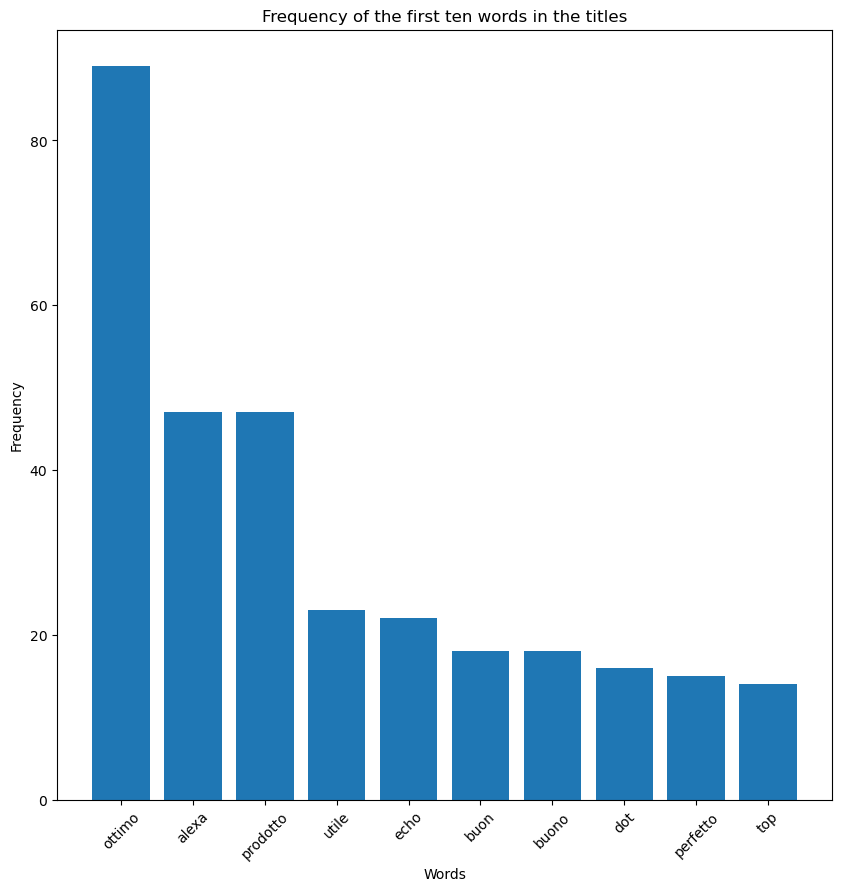

In [205]:
plt.figure(figsize=(10,10))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the titles')
plt.bar(list(sorted_fd_title.keys())[:10], list(sorted_fd_title.values())[:10])
plt.show()

In [206]:
list_body = df['Body'].to_list()
list_body = [str(word) for word in list_body]
words_body = [word for text in list_body for word in nltk.word_tokenize(text)]
words_body_clear = [w for w in words_body if w.lower() not in stopwords]
words_body_clear = [char for char in words_body_clear if char.isalpha()]

In [207]:
fd_body = nltk.FreqDist(words_body_clear)

In [208]:
sorted_fd_body = dict(sorted(fd_body.items(), key=lambda item: item[1], reverse=True))

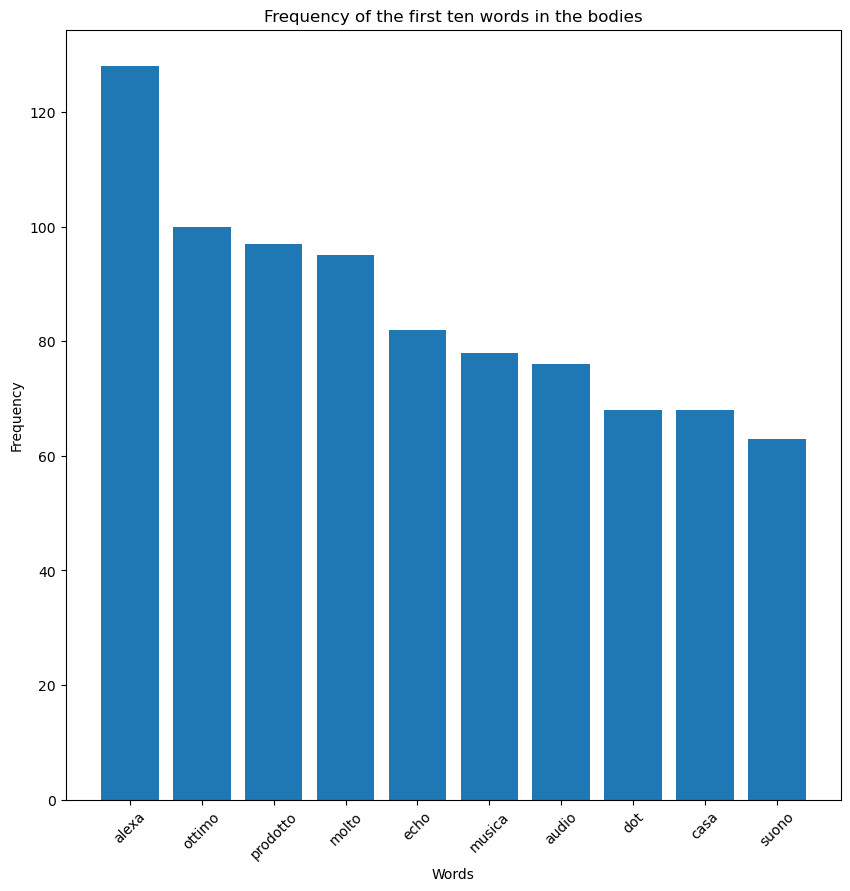

In [209]:
plt.figure(figsize=(10,10))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the bodies')
plt.bar(list(sorted_fd_body.keys())[:10], list(sorted_fd_body.values())[:10])
plt.show()

In [217]:
positive_reviews = df[df['Stars'] >= 4]['Title']
positive_reviews = ".".join(positive_reviews)

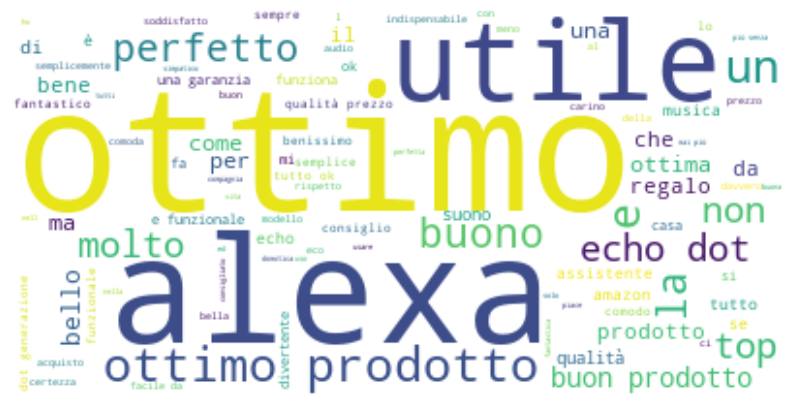

In [218]:
wordcloud = WordCloud(background_color="white", max_words=len(positive_reviews))

wordcloud.generate(positive_reviews)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [221]:
negative_reviews = df[df['Stars'] <= 3]['Title']
negative_reviews = ".".join(negative_reviews)

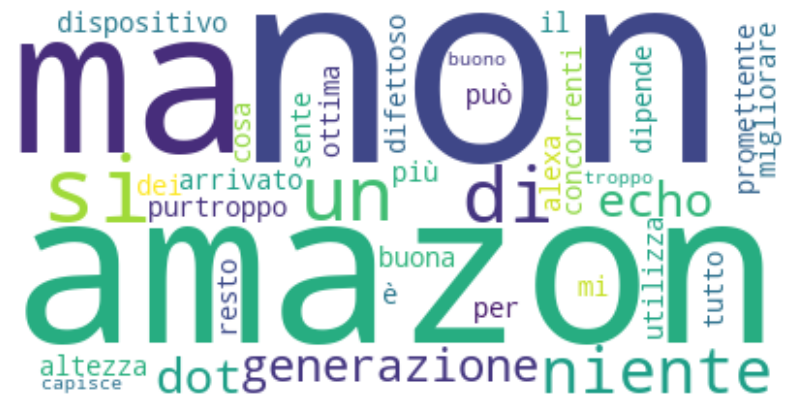

In [222]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_reviews))

wordcloud.generate(negative_reviews)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [223]:
sia = SentimentIntensityAnalyzer()
title_polarity = [sia.polarity_scores(str(element)) for element in df['Title']]
body_polarity = [sia.polarity_scores(str(element)) for element in df['Body']]

In [224]:
title_pol_mean = []

for i in range(len(title_polarity)):
    if title_polarity[i]['compound'] == 0.0:
        title_pol_mean.append(0.5)
    else:
        title_pol_mean.append(title_polarity[i]['compound'])

In [225]:
body_pol_mean = []

for i in range(len(body_polarity)):
    if body_polarity[i]['compound'] == 0.0:
        body_pol_mean.append(0.5)
    else:
        body_pol_mean.append(body_polarity[i]['compound'])

In [226]:
total_polarity = []
total_polarity = [round((i*0.2 + j*0.8)/2, 4) for i,j in zip(title_pol_mean, body_pol_mean)]

In [227]:
df['Polarity'] = total_polarity

In [228]:
list_polarity = []
for i in range(len(df)):
    if df['Polarity'][i] < 0:
        list_polarity.append('Bad')
    else:
        list_polarity.append('Good')

df['Polarity_Text'] = list_polarity

In [229]:
df['Polarity_Text'].value_counts()

Good    444
Bad      66
Name: Polarity_Text, dtype: int64

In [230]:
df.to_csv('data_final.csv', index=False)

In [231]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Body'])
feature_names = vectorizer.get_feature_names_out()
matrix = vectors.todense()
list_dense = matrix.tolist()
sparse_matrix = pd.DataFrame(list_dense, columns=feature_names)

In [233]:
sparse_matrix['Polarity_Text'] = list_polarity

In [234]:
X = sparse_matrix.iloc[:,0:-2]
Y = sparse_matrix.iloc[:, -1]

## Models

In [235]:
# Naive Bayes
nb = GaussianNB()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
                                                    
nb.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6568627450980392


In [236]:
# Decision Tree
dt = DecisionTreeClassifier()

# Train the classifier
dt.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9901960784313726


In [237]:
# Random Forest
rf = RandomForestClassifier()

# Train the classifier
rf.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9117647058823529


In [185]:
# logistic regression
lr = LogisticRegression()

# Train the classifier
lr.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8529411764705882


In [238]:
# Create a KNN classifier
k = 10  # number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn.fit(X_train, Y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9019607843137255
